In [48]:
import os
import json
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datasets import load_dataset
from pathlib import Path

## Load MusicCaps dataset

In [40]:
ds = load_dataset("google/MusicCaps")
df_train = ds['train'].to_pandas()
df_train['aspect_list_transformed'] = df_train['aspect_list'].apply(ast.literal_eval)

### Analyse tag counts for concept extraction

In [3]:
tag_counts = {}
for aspects in df_train['aspect_list_transformed']:
    for tag in aspects:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['Tag', 'Count'])
tag_counts_df = tag_counts_df.sort_values(by='Count', ascending=False)

/tmp/ipykernel_40686/592743751.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')


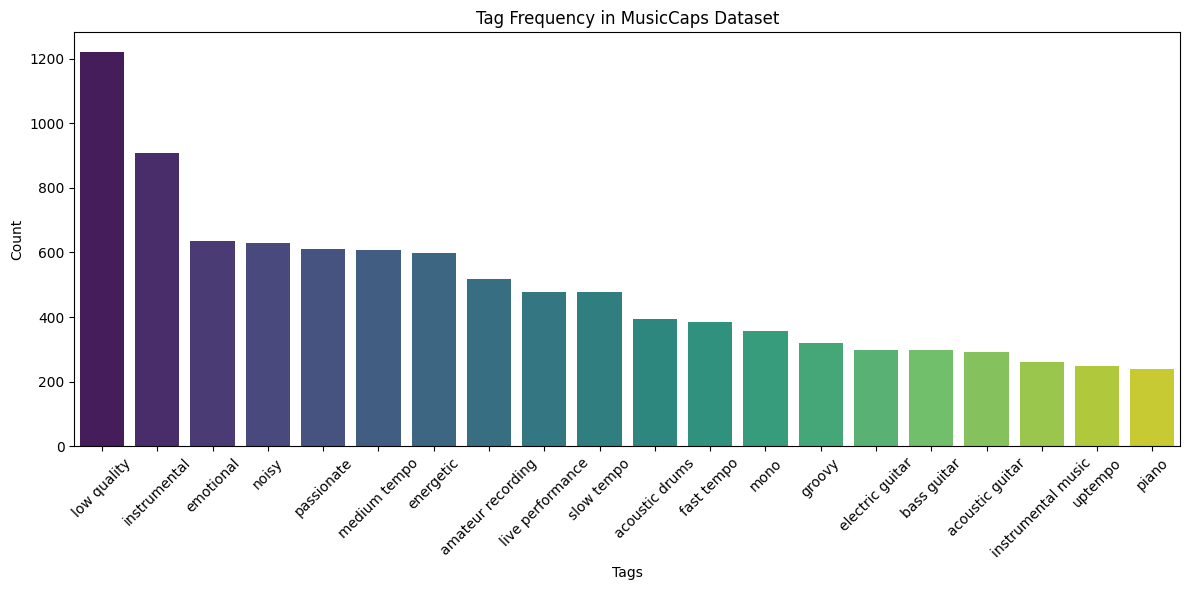

In [4]:
_tag_counts_df = tag_counts_df.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Tag Frequency in MusicCaps Dataset')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
tag_counts_df.to_csv("../data/musiccaps_tag_frequencies.csv", index=False)

## Prepare concept dataset

In [41]:
def extract_tags(song_tags, concept_tags):
    res = []
    for c_tag in concept_tags:
        for s_tag in song_tags:
            if c_tag == s_tag:
                res.append(s_tag)
    return list(set(res))

In [42]:
concepts = json.load(open("../data/concepts_to_tags.json", "r"))

for concept, tags in concepts.items():
    df_train[concept + '_tags'] = df_train['aspect_list_transformed'].apply(
        lambda x: extract_tags(x, tags)
    )

In [43]:
df_train = df_train[["caption", "aspect_list_transformed", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train = df_train[(df_train['genre_tags'].map(len) > 0) & 
                    (df_train['instrument_tags'].map(len) > 0)] 
df_train["combined_tags"] = df_train["tempo_tags"] + df_train["genre_tags"] + df_train["mood_tags"] + df_train["instrument_tags"]
df_train["aspect_list"] = df_train["combined_tags"].apply(lambda x: ', '.join(x))
df_train["tempo_tags"] = df_train["tempo_tags"].apply(lambda x: ', '.join(x))
df_train["genre_tags"] = df_train["genre_tags"].apply(lambda x: ', '.join(x))
df_train["mood_tags"] = df_train["mood_tags"].apply(lambda x: ', '.join(x))
df_train["instrument_tags"] = df_train["instrument_tags"].apply(lambda x: ', '.join(x))
df_train = df_train[["caption", "aspect_list", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train

,caption,aspect_list,tempo_tags,genre_tags,mood_tags,instrument_tags
0,The low quality recording features a ballad so...,"soulful, ballad, sad, mellow piano melody, sus...",,"soulful, ballad","sad, mellow piano melody",sustained strings melody
3,This song contains digital drums playing a sim...,"medium tempo, jazzy, e-bass, trumpet, acoustic...",medium tempo,jazzy,,"e-bass, trumpet, acoustic guitar, digital drum..."
6,A male singer sings this groovy melody. The so...,"techno dance rhythm, medium tempo, ambient noi...","techno dance rhythm, medium tempo",ambient noises,,"keyboard accompaniment, groovy bass line, male..."
8,The Pop song features a soft female vocal sing...,"pop, sad, passionate, emotional, mellow piano ...",,pop,"sad, passionate, emotional, mellow piano melody","punchy kick, claps"
11,This folk song features a male voice singing t...,"slow tempo, folk music, accordion, violin, mal...",slow tempo,folk music,,"accordion, violin, male voice"
...,...,...,...,...,...,...
5507,A male vocalist sings this energetic song. The...,"rock, energetic drumming, male vocalist",,rock,energetic drumming,male vocalist
5509,This dance song features a female voice singin...,"moderate tempo, dance song, happy mood, female...",moderate tempo,dance song,happy mood,"female voice, synth sounds, programmed percuss..."
5512,This amateur recording features the sound of t...,"ambient noises, no voices",,ambient noises,,no voices
5519,The song is an instrumental. The song is slow ...,"slow tempo, christian contemporary music, groo...","slow tempo, christian contemporary music, groo...","meditational, instrumental music","passionate, emotional, poignant","keyboard accompaniment, piano accompaniment, s..."


In [44]:
df_train.to_csv("../data/musiccaps_tags_to_description_dataset.csv", index=False)

## Analyse dataset

In [45]:
# Display basic statistics
tag_columns = ["tempo_tags", "genre_tags", "mood_tags", "instrument_tags", "aspect_list"]
for col in tag_columns:
    df_train[col + '_count'] = df_train[col].apply(lambda x: len(x.split(', ')))
display(df_train[[col + '_count' for col in tag_columns]].describe())

,tempo_tags_count,genre_tags_count,mood_tags_count,instrument_tags_count,aspect_list_count
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,1.242586,1.469130,1.710744,2.487117,6.183763
std,0.601534,0.875601,1.098481,1.371952,2.530989
min,1.000000,1.000000,1.000000,1.000000,2.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000
50%,1.000000,1.000000,1.000000,2.000000,6.000000
75%,1.000000,2.000000,2.000000,3.000000,8.000000
max,6.000000,7.000000,8.000000,8.000000,18.000000


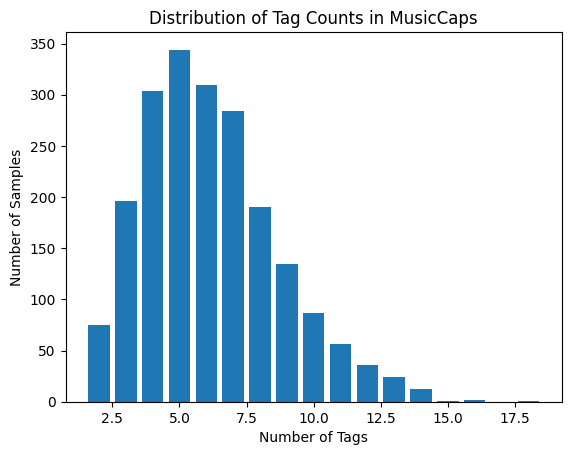

In [47]:
# calculate tag len distribution
tag_len_counts = df_train['aspect_list'].map(lambda x: len(x.split(', '))).value_counts().sort_index()
plt.bar(tag_len_counts.index, tag_len_counts.values)
plt.xlabel("Number of Tags")
plt.ylabel("Number of Samples")
plt.title("Distribution of Tag Counts in MusicCaps")
plt.show()

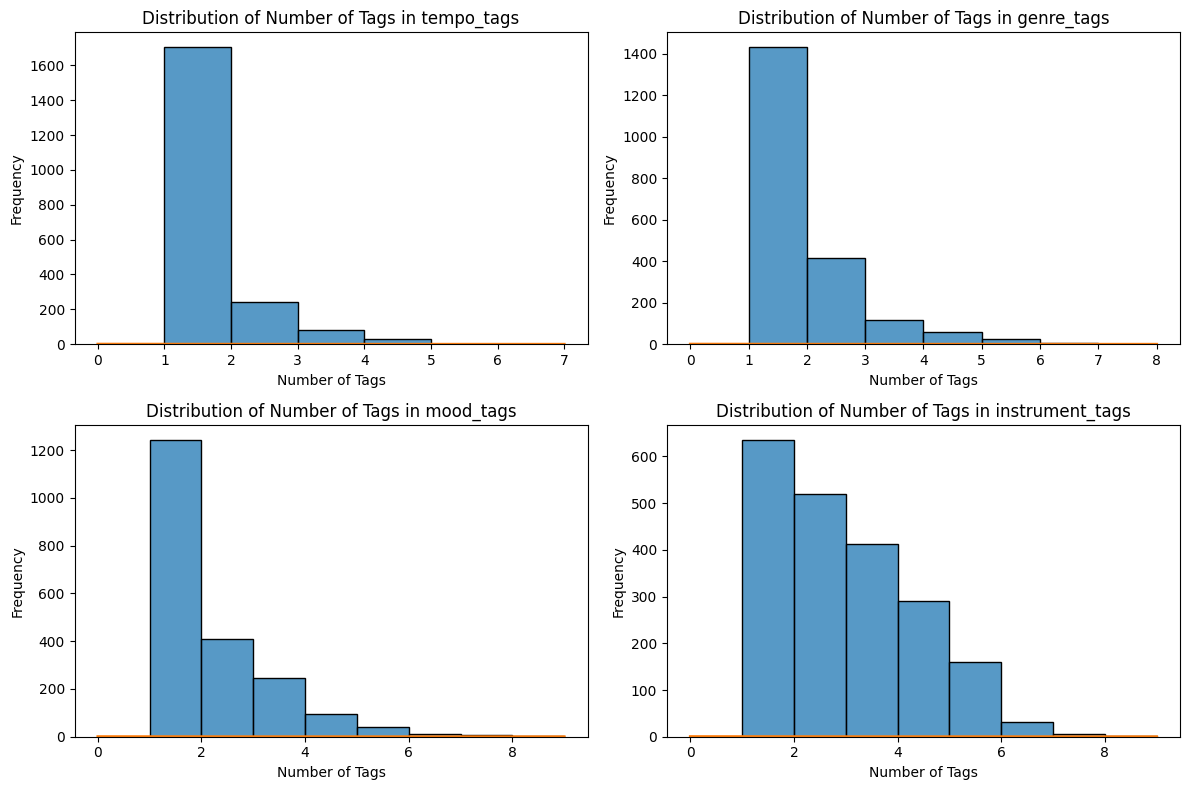

In [ ]:
# Plot distribution of number of tags per category
tag_columns = ["tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]
plt.figure(figsize=(12, 8))
for i, col in enumerate(tag_columns, 1):
    plt.subplot(2, 2, i)
    tag_counts = df_train[col].apply(lambda x: len(x.split(', ')))
    sns.histplot(tag_counts, bins=range(1, tag_counts.max() + 2), kde=False)
    plt.title(f'Distribution of Number of Tags in {col}')
    plt.xlabel('Number of Tags')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

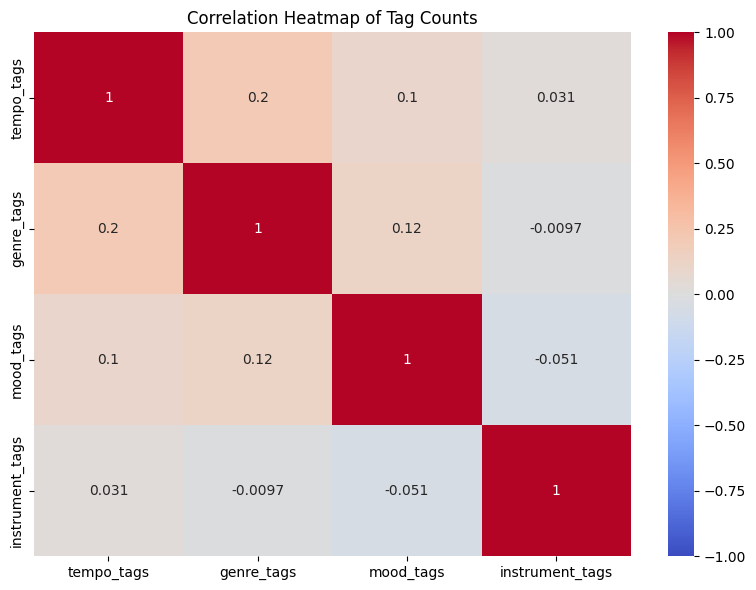

In [38]:
# Correlation heatmap of tag counts
tag_count_data = {}
for col in tag_columns:
    tag_count_data[col] = df_train[col].apply(lambda x: len(x.split(', ')))
tag_count_df = pd.DataFrame(tag_count_data)
plt.figure(figsize=(8, 6))
sns.heatmap(tag_count_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Tag Counts')
plt.tight_layout()
plt.show()

## Save final dataset

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

In [8]:
# Create output directory
output_dir = Path("../data/tags")
output_dir.mkdir(parents=True, exist_ok=True)

df_train.to_csv(output_dir / "train.csv", index=False)
df_valid.to_csv(output_dir / "validation.csv", index=False)
df_test.to_csv(output_dir / "test.csv", index=False)
all_df = pd.concat([df_train, df_valid, df_test])
all_df.to_csv(output_dir / "all.csv", index=False)

In [10]:
data_files = {
    "train": str(output_dir / "train.csv"),
    "validation": str(output_dir / "validation.csv"),
    "test": str(output_dir / "test.csv")
}
dataset = load_dataset("csv", data_files=data_files)
dataset.push_to_hub("bsienkiewicz/musiccaps-tags-to-caption", private=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption/commit/788f21b192e6558e01c0fe6827bc3bcf8149257a', commit_message='Upload dataset', commit_description='', oid='788f21b192e6558e01c0fe6827bc3bcf8149257a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/musiccaps-tags-to-caption'), pr_revision=None, pr_num=None)